In [2]:
# Important, set your home directory here:
home_dir = ''

In [3]:
import os 
os.chdir(home_dir)

import numpy as np
import pandas as pd
import pickle

import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from scipy.interpolate import interp1d
import scipy.stats as scs

import seaborn as sns
import matplotlib.pyplot as plt

In [29]:
%load_ext autoreload
%autoreload 2
from main.fairness.paramfitter import LocationScaleGumbel
from main.fairness.wasserstein import WassersteinBinary
from main.models.utils import preprocess_census, cv_early_stopping
from main.fairness.metrics import unfairness
from main.loaders.loader_folktabs import load_income_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Train paramatric class with Californian data

In [ ]:
data_income = load_income_data(states=['CA'])

cat_features = ['OCCP', 'POBP', 'SCHL', 'RELP']

preprocessed_dict = preprocess_census(data_income, 
                                      target_feature='PINCP',
                                      sensitive_features=['SEX'], 
                                      categorical_features=cat_features,
                                      continuous_features=['WKHP', 'AGEP'], 
                                      target_processing='log')

params = {
    "objective": "regression",
    "metric": "mse",
    "min_data_in_leaf": 50,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "verbose": -1
}

cv_results = cv_early_stopping(params=params, 
                               nfolds=5, 
                               max_rounds=1000, 
                               early_stopping_rounds=20, 
                               X_train=preprocessed_dict['X_train'], 
                               y_train=preprocessed_dict['y_train'], 
                               categorical_feats=cat_features)


best_res = np.argmin(cv_results['metric'])
best_iter = cv_results['iterations'][best_res]

print((f"Best MSE: {np.min(cv_results['metric'])} \nBest Iter: {best_iter}"))

# Retrain whole model
data_train_all = lgb.Dataset(data=preprocessed_dict['X_train'], 
                             label=preprocessed_dict['y_train'], 
                             categorical_feature=cat_features)

best_estimator = lgb.train(params=params,
                           train_set=data_train_all, 
                           num_boost_round=best_iter)


preds_uncorrected_calib = best_estimator.predict(preprocessed_dict['X_train'])
preds_uncorrected_test = best_estimator.predict(preprocessed_dict['X_test'])

sens_calib = np.where(preprocessed_dict['X_train'].RAC1P_black == 1, 1, 0)
sens_test = np.where(preprocessed_dict['X_test'].RAC1P_black == 1, 1, 0)

fairness_trans = WassersteinBinary()
fairness_trans.fit(preds_uncorrected_calib, sens_calib)

nonparam_preds_calib = fairness_trans.transform(preds_uncorrected_calib, sens_calib)
nonparam_preds_test = fairness_trans.transform(preds_uncorrected_test, sens_test)


parametric_sampler = LocationScaleGumbel()

parametric_sampler.fit(X=np.array(nonparam_preds_calib), 
                           sampling_obs=len(nonparam_preds_calib)*50)

    
parametric_preds = parametric_sampler.sample(n=len(nonparam_preds_test), 
                                                mc_samples=20)


interpolator = interp1d(np.sort(nonparam_preds_test),
                            parametric_preds, fill_value='extrapolate')
    
param_preds_test = interpolator(nonparam_preds_test)

In [25]:
parametric_sampler = LocationScaleGumbel()

parametric_sampler.fit(X=np.array(nonparam_preds_calib), 
                           sampling_obs=len(nonparam_preds_calib)*50)

    
parametric_preds = parametric_sampler.sample(n=len(nonparam_preds_test), 
                                                mc_samples=20)


interpolator = interp1d(np.sort(nonparam_preds_test),
                            parametric_preds, fill_value='extrapolate')
    
param_preds_test = interpolator(nonparam_preds_test)

Optimization terminated successfully.
         Current function value: 0.041882
         Iterations: 107
         Function evaluations: 202


<Axes: ylabel='Density'>

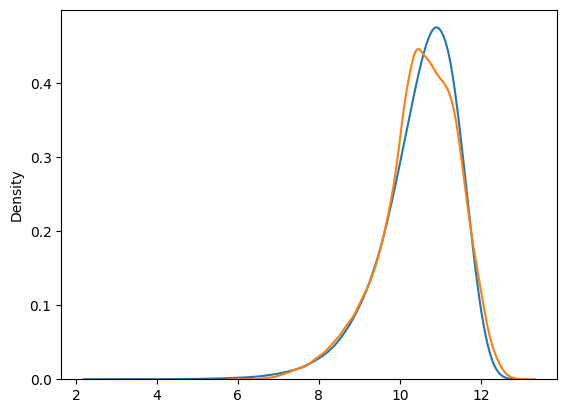

In [26]:
sns.kdeplot(param_preds_test)
sns.kdeplot(nonparam_preds_test)

Fit looks good

# Now run experiments on Texan Data

In [ ]:
results_dict = {}

for seed_ in [42, 1029, 3948, 103, 56, 93983838, 828, 1928838, 900, 10]:
    results_dict[seed_] = {}

    data_income = load_income_data(states=['TX'])

    cat_features = ['OCCP', 'POBP', 'SCHL', 'RELP']

    preprocessed_dict = preprocess_census(data_income, 
                                        target_feature='PINCP',
                                        sensitive_features=['SEX'], 
                                        categorical_features=cat_features,
                                        continuous_features=['WKHP', 'AGEP'], 
                                        target_processing='log', 
                                        split_seed=seed_)
    
    for missing_prop in [0, 0.25, 0.5, 0.75]:
        results_dict[seed_][missing_prop] = {}

        error_obs = scs.bernoulli(missing_prop).rvs(int(len(preprocessed_dict['y_train'])))
        data_errors = scs.gamma(1,.5).rvs(size=int(len(preprocessed_dict['y_train'])))
        error_vec = error_obs*data_errors
        preprocessed_dict['y_train'] += error_vec

        params = {
            "objective": "regression",
            "metric": "mse",
            "min_data_in_leaf": 50,
            "learning_rate": 0.05,
            "feature_fraction": 0.9,
            "verbose": -1
        }

        cv_results = cv_early_stopping(params=params, 
                                    nfolds=5, 
                                    max_rounds=1000, 
                                    early_stopping_rounds=20, 
                                    X_train=preprocessed_dict['X_train'], 
                                    y_train=preprocessed_dict['y_train'], 
                                    categorical_feats=cat_features)

        best_res = np.argmin(cv_results['metric'])
        best_iter = cv_results['iterations'][best_res]

        print((f"Best MSE: {np.min(cv_results['metric'])} \nBest Iter: {best_iter}"))


        # Retrain whole model
        data_train_all = lgb.Dataset(data=preprocessed_dict['X_train'], 
                                    label=preprocessed_dict['y_train'], 
                                    categorical_feature=cat_features)

        best_estimator = lgb.train(params=params,
                                train_set=data_train_all, 
                                num_boost_round=best_iter)


        preds_uncorrected_calib = best_estimator.predict(preprocessed_dict['X_train'])
        preds_uncorrected_test = best_estimator.predict(preprocessed_dict['X_test'])

        sens_calib = np.where(preprocessed_dict['X_train'].RAC1P_black == 1, 1, 0)
        sens_test = np.where(preprocessed_dict['X_test'].RAC1P_black == 1, 1, 0)

        fairness_trans = WassersteinBinary()
        fairness_trans.fit(preds_uncorrected_calib, sens_calib)

        nonparam_preds_calib = fairness_trans.transform(preds_uncorrected_calib, sens_calib)
        nonparam_preds_test = fairness_trans.transform(preds_uncorrected_test, sens_test)
        
        # Interpolate with previously fitted Gumbel
        param_preds_test = interpolator(nonparam_preds_test)

        results_dict[seed_][missing_prop]['mse_nonparam'] = mean_squared_error(preprocessed_dict['y_test'], nonparam_preds_test)
        results_dict[seed_][missing_prop]['mse_param'] = mean_squared_error(preprocessed_dict['y_test'], param_preds_test)

        results_dict[seed_][missing_prop]['unfair_nonparam'] = unfairness(nonparam_preds_test[sens_test == 1],  nonparam_preds_test[sens_test != 1])
        results_dict[seed_][missing_prop]['unfair_param'] = unfairness(param_preds_test[sens_test == 1],  param_preds_test[sens_test != 1])

    with open(f'data/results/folktabs/dicts/dict_corrupted.pkl', 'wb') as con_:
        pickle.dump(results_dict, con_)